In [1]:
from nn import NeuralNetwork
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

## Load in data, make training (80%) and validation (20%) sets

In [2]:
data = load_digits()["data"]
n = data.shape[0]
train_rows = int(0.8*n) # 80% train, 20% validation

In [3]:
np.random.shuffle(data)
X_train, X_val = data[0:train_rows, :], data[train_rows:n, :]

## Train autoencoder, searching over grid of hyperparameters

In [4]:
epochs = [10, 20, 30, 40, 50]
lrs = [10, 1, 0.1, 0.01, 0.001]
batch_sizes = [100, 200, 300, 400, 500]
activations = ["relu", "sigmoid"]
val_loss = np.zeros((len(epochs), len(lrs), len(batch_sizes), len(activations))) # validation loss as a function of the hyperparameters

In [5]:
for e, epoch in enumerate(epochs):
    for l, lr in enumerate(lrs):
        for b, batch_size in enumerate(batch_sizes):
            for a, activation in enumerate(activations):
                
                net = NeuralNetwork([{'input_dim': 64, 'output_dim': 16, 'activation': activation},
                                     {'input_dim': 16, 'output_dim': 64, 'activation': activation}],
                                    lr, 42, batch_size, epoch, "mse")
                
                # this is a reconstruction task, so the data and the target are the same 
                net.fit(X_train, X_train, X_val, X_val)
                # get validation loss
                val_loss[e, l, b, a] = net._mean_squared_error(X_val, net.predict(X_val))

/Users/grantgoldman/Library/Python/3.7/lib/python/site-packages/nn/nn.py:362: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(Z))


In [6]:
# get one set of best hyperparameters (potentially could be more than one)
min_val_loss_idxs = np.where(val_loss == np.min(val_loss))
one_min_idx = [x[0] for x in min_val_loss_idxs]
epoch, lr, batch_size, activation = epochs[one_min_idx[0]], lrs[one_min_idx[1]], batch_sizes[one_min_idx[2]], activations[one_min_idx[3]]
print(f"Selected hyperparameters: epochs: {epoch}, learning rate: {lr}, batch_size: {batch_size}, activation: {activation}")

Selected hyperparameters: epochs: 50, learning rate: 0.1, batch_size: 100, activation: sigmoid


## Explanation of Hyperparameters

### I selected my hyperparameters by searching over a large space of potential hyperparameter combinations. I trained a new model on each distinct combination and kept track of the loss validation at the end of training. Then, I selected the combination of hyperparameters that minimized the validation loss. 

- Epochs: number of passes through the data
- Learning rate: how far of a "step" to move the weights and bias in the direction of the gradient
- Batch size: how large of a subset of the data to estimate the gradient with
- Activation: nonlinear activation on each neuron

## Now, run the model with the best performing hyperparameters

In [7]:
net = NeuralNetwork([{'input_dim': 64, 'output_dim': 16, 'activation': "sigmoid"},
                     {'input_dim': 16, 'output_dim': 64, 'activation': "sigmoid"}],
                    lr, 42, batch_size, epoch, "mse")
train_loss, val_loss = net.fit(X_train, X_train, X_val, X_val)

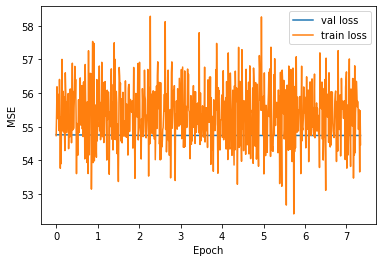

In [10]:
epochs = [x/batch_size for x in range(len(train_loss))]
plt.plot(epochs, val_loss, label="val loss")
plt.plot(epochs, train_loss, label="train loss")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend()

## Quantify validation loss

In [11]:
val_loss[-1]

54.742340820734555

### The validation loss is relatively high for this task. This may be because the latent space dimensionality (16) is too small to accurately reconstruct the data, or perhaps the model needs more than one hidden later for reconstruction.